# PROGETTO DIGITAL SIGNAL IMAGE MANAGEMENT
### CLASSIFICAZIONE IMMAGINI

Cattaneo Andrea, matricola n°815585, a.cattaneo66@campus.unimib.it\
Marinoni Andrea, matricola n°799690, a.marinoni14@campus.unimib.it\
Marzorati Stefano, matricola n°830272, s.marzorati11@campus.unimib.it 

La seconda parte del progetto si pone l'obiettivo di effettuare una classificazione di immagini.\
Il dataset utilizzato per l'addestramento del modello è costituito da una cartella denominata "immagini_nostre" contente tre ulteriori sottocartelle corrispondenti alle tre diverse classi di appartenenza delle immagini.
- **rimbalzino**: classe attribuita a immagini di Andrea Cattaneo
- **big_mari**: classe attribuita a immagini di Andrea Marinoni
- **ste_manzo**: classe attribuita a immagini di Stefano Marzorati

# CLASSIFICAZIONE FACCE

## Preparazione Dataset

###  Librerie

In [ ]:
from tensorflow import keras
keras.__version__

'2.8.0'

In [ ]:
import tarfile
from time import time
from shutil import copyfile

In [ ]:
import os
import cv2 as cv
from google.colab.patches import cv2_imshow

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
import numpy as np
from sklearn.preprocessing import LabelEncoder

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
from keras.callbacks import EarlyStopping

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

In [ ]:
import time

In [ ]:
from pickle import dump, load

### Spostamento file

La macchina virtuale, colab, viene collegata alla repository di Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Caricamento file dall'archivio

La cartella desiderata viene importata ed estratta dal file compresso, in modo da migliorare le performance di caricamento ed averla disponibile durante lo studio.

In [ ]:
import zipfile 

# Transfer zip dataset to the current virtual machine
copyfile('gdrive/My Drive/DSIM_project/immagini_nostre.zip', 'immagini_nostre.zip')
# Extract files
zip = zipfile.ZipFile('immagini_nostre.zip')
zip.extractall()
zip.close()

In [ ]:
base_path = 'immagini_nostre/'

In [ ]:
face_path = 'facce_nostre/'

### Crop faccia

Il Crop viene eseguito per rimuovere tutti gli oggetti e le aree indesiderate da un'immagine. Può essere anche utilizzato per evidenziare caratteristiche importanti. In questo caso è stato usato per isolare i volti presenti nell'immagine.  
Dato che le immagini contenute nel dataset raffiguravano una sola faccia, si è deciso di tenere solo la prima faccia riconosciuta dall'algoritmo, che coincide con la faccia effettiva.

In [ ]:
def load_faces(face_path, base_path, min_height, min_width):
  os.mkdir(face_path)
  for folder in os.listdir(base_path):
    os.mkdir(face_path+folder)
    for file in os.listdir(base_path+folder):
      img = cv.imread(base_path+folder+'/'+file)
      gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
      face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')
      faces = face_cascade.detectMultiScale(gray, minSize = (min_height, min_width))
      if len(faces)>0:
        x, y, w, h = faces[0]
        faces = img[y:y + h, x:x + w]
        cv.imwrite(face_path+folder+'/'+file, faces)

Per ottimizzare la ricerca dei volti all'interno del dataset è stata impostata una dimensione minima che una faccia candidata deve rispettare, in questo caso 400x400 pixel

In [ ]:
load_faces(face_path, base_path, 400,400)

### Train e Test Set

Si creano dei modelli per la classificazione dei volti.  
Per l'addestramento e la valutazione della bontà del modello il dataset viene diviso in train set e test set.
-  Train Set: 70% del dataset
-  Test Set: 30% del dataset  

Di seguito sono presenti le funzioni utilizzate per il caricamento del dataset, il suo splitting e la preparazione per l'uso con i modelli.

In [ ]:
CATEGORIES = ['big_mari', 'rimbalzino', 'ste_manzo']

In [ ]:
IMG_SIZE =224

In [ ]:
data = []
for category in CATEGORIES:
  path = os.path.join(face_path, category)
  for img in os.listdir(path):
    img_array = cv.imread(os.path.join(path,img))
    img_array = cv.resize(img_array, (IMG_SIZE, IMG_SIZE))
    data.append([img_array, category])

In [ ]:
print(len(data))

285


In [ ]:
count_bigmari = 0
count_rimbalzino = 0
count_stemanzo = 0
for image in data:
    if image[1] == 'big_mari':
        count_bigmari += 1
    if image[1] == 'rimbalzino':
        count_rimbalzino += 1
    if image[1] == 'ste_manzo':
        count_stemanzo += 1
print('bigmari:', count_bigmari, 'rimbalzino:', count_rimbalzino, 'stemanzo:', count_stemanzo)

bigmari: 97 rimbalzino: 94 stemanzo: 94


In [ ]:
X = []
Y = []
for features, labels in data:
  X.append(features)
  Y.append(labels)

In [ ]:
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=1, shuffle = True)

Il seguente codice permette di trasformare le label dei dati in formato categorico tramite l'uso di un encoder.

In [ ]:
num_classes = 3
label_encoder = LabelEncoder()
YC_train = label_encoder.fit_transform(Y_train)
YC_test = label_encoder.transform(Y_test)

YC_train = keras.utils.to_categorical(YC_train, num_classes)
YC_test = keras.utils.to_categorical(YC_test, num_classes)

dump(label_encoder, open('labelEncoderImg.pkl', 'wb'))

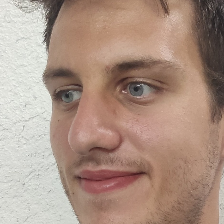

In [ ]:
cv2_imshow(X_train[62])

#Mobile V2 Net 

## Senza Early Stopping


### Rete Base

Si importa il modello preaddestrato MobileNetV2, si basa su una struttura residua invertita in cui l'input e l'output del blocco residuo sono strati di collo di bottiglia sottili opposti ai modelli residui tradizionali che utilizzano rappresentazioni espanse nell'input.  
MobileNetV2 utilizza convoluzioni in profondità per filtrare le caratteristiche nello strato di espansione intermedio.   Inoltre rimuove le non linearità negli strati stretti per mantenere il potere rappresentativo.  
Infine, consente il disaccoppiamento dei domini input/output dall'espressività della trasformazione, il che fornisce un quadro conveniente per ulteriori analisi.

Viene scaricata la rete base preaddestrata su imagenet, escludendo i layer finali di output, poichè non la mappatura agli output della rete originale.

In [ ]:
base_net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


### Specializzazione della rete

I layer di base_net sono stati bloccati ("freeze_layers") in modo che i pesi non vengano riaddestrati e siano mantenuti quelli preaddestrati

In [ ]:
def freeze_layers(net):
  for layer in net.layers:
    layer.trainable = False

In [ ]:
freeze_layers(base_net)

Vengono inizializzate le caratteristiche dell'input che le immagini dovranno rispettare, in particolare le dimensioni.

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

### Data Augmentation

Al fine di migliorare le capacità di generalizzazione del modello si è deciso di attuare un insieme di tecniche di data augmentation, che permettessero di fornire maggiori informazioni al modello.

Si è deciso di effettuare la data augmentation attraverso alcune trasformazioni spaziali: "rotation", "flip", "translation", "zoom" e attraverso la modifica del contrasto.

In [ ]:
def data_augmentation(data):
  data = keras.layers.RandomFlip(mode= 'horizontal_and_vertical', seed=1)(data)
  data = keras.layers.RandomTranslation(height_factor= 0.2, width_factor=0.2,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=1,
    fill_value=0.0,)(data)
  
  data = keras.layers.RandomRotation(
    factor=0.2,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=1,
    fill_value=0.0
  )(data)
  data = keras.layers.RandomZoom(
    height_factor = (0.2, 0.3),
    width_factor=None,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=1,
    fill_value=0.0
  )(data)
  data = keras.layers.RandomContrast(factor= 0.8, seed=1)(data)
  return data

In [ ]:
x= data_augmentation(x)

### Preprocessing

Per utilizzare in modo corretto la rete già addestrata (MobileNetv2) bisogna applicare al dataset a disposizione il medesimo 
preprocessing utilizzato sui dati per addestrare la rete.

In [ ]:
x = keras.applications.mobilenet_v2.preprocess_input(x)

### Specializzazione

Il modello preaddestrato è stato poi adeguato al caso specifico aggiungendo:

- un **layer di GlobalAveragePooling**, al fine di ridurre le dimensioni delle attivazioni senza sacrificare le prestazioni.

- un **layer dense** (o **fully connected**), aiuta a modificare la dimensionalità dell'output dal livello precedente in modo che il modello possa definire facilmente la relazione tra i valori dei dati su cui il modello sta lavorando. 

- un **layer di Batch Normalization**, che consente di normalizzare gli output del layer di convoluzione per ogni batch.\
La normalizzazione batch applica una trasformazione che mantiene l'output medio vicino a 0 e la deviazione standard dell'output vicina ad 1, in modo da rendere maggiormente stabile la rete, al di là del numero di batch utilizzato.

- un **layer di dropout**, nel quale ogni unità nascosta (neurone) viene posta a 0 con una probabilità di 0,3. 

- un'altro **layer dense** (o **fully connected**)

- un **layer di dropout**, nel quale ogni unità nascosta (neurone) viene posta a 0 con una probabilità di 0,1. 

- un'ulteriore **layer dense**

- un **layer fully connected** che permette di mappare l'output, ossia effettua la classificazione delle immagini di input, in base alle tre classi di riferimento ("rimbalzino", "big mari", "stemanzo"). In particolare, esso utilizza una rete neurale densa (Multi layer Perceptron), con funzione di attivazione "Softmax".

In [ ]:
# Output of the base model
x = base_net(x)
x =keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dense(512, activation = "relu")(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(128, activation = "relu")(x)
x=keras.layers.Dropout(0.1)(x)
x=keras.layers.Dense(32, activation = "relu")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

### Creazione modello

In [ ]:
# Specialized model
net = keras.Model(inputs=inputs, outputs=outputs)

Vengono mostrati i layer che compongono il modello

In [ ]:
net.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_translation (RandomT  (None, 224, 224, 3)      0         
 ranslation)                                                     
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 224, 224, 3)      0     

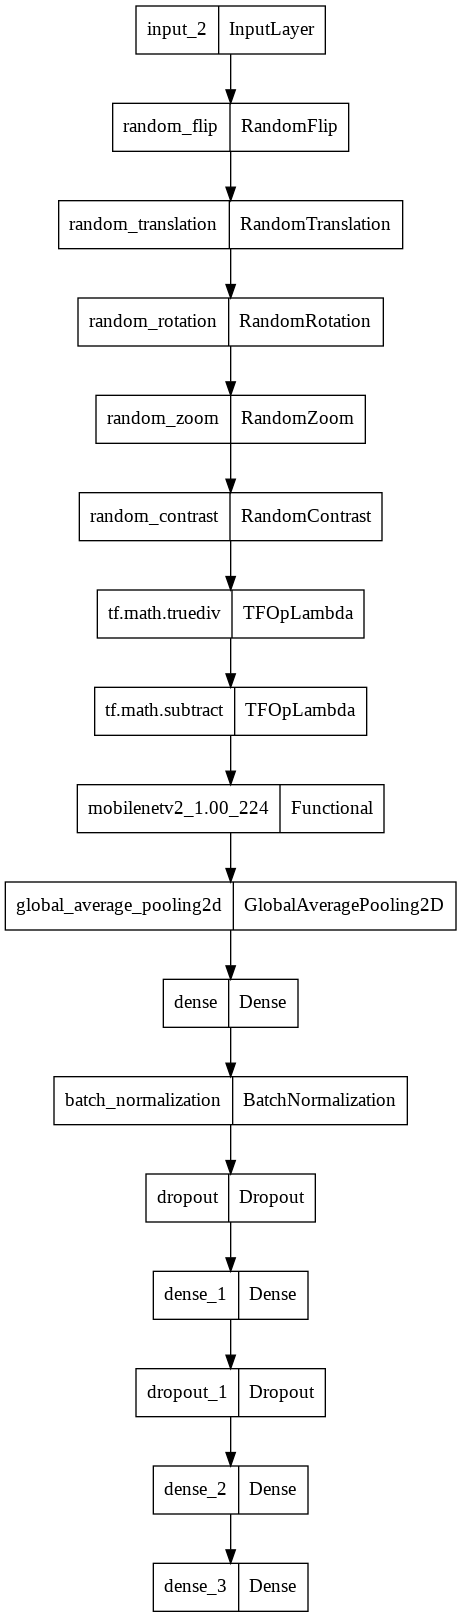

In [ ]:
keras.utils.plot_model(net)

### Training e fine tuning

Per quanto concerne l'addestramento del modello, si è scelto "RMSprop" come **ottimizzatore**, "categorical crossentropy" come **funzione di loss**\
Inoltre, si è utilizzata una metrica human readable per valutare il modello, in particolare, si è deciso di utilizzare l'accuracy, essendo le classi del dataset bilanciate.\
Infine, il training è stato eseguito su 80 epoche, misura ritenuta un buon compromesso tra efficacia dell'addestramento e tempi di esecuzione.

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

Per l'addestramento del modello viene scelta una percentuale del dataset da tenere come validation set, in particolare il 20% del training set.

In [ ]:
history = net.fit(X_train, YC_train,
          epochs=80,
          validation_split= 0.2, batch_size = 32);

Epoch 1/80
5/5 [==============================] - 17s 492ms/step - loss: 0.7781 - accuracy: 0.6226 - val_loss: 0.6848 - val_accuracy: 0.4500
Epoch 2/80
5/5 [==============================] - 0s 67ms/step - loss: 0.2858 - accuracy: 0.8616 - val_loss: 0.6318 - val_accuracy: 0.5500
Epoch 3/80
5/5 [==============================] - 0s 63ms/step - loss: 0.3328 - accuracy: 0.8616 - val_loss: 0.8351 - val_accuracy: 0.5500
Epoch 4/80
5/5 [==============================] - 0s 64ms/step - loss: 0.2056 - accuracy: 0.9245 - val_loss: 1.0188 - val_accuracy: 0.6250
Epoch 5/80
5/5 [==============================] - 0s 65ms/step - loss: 0.1698 - accuracy: 0.9434 - val_loss: 0.8299 - val_accuracy: 0.6250
Epoch 6/80
5/5 [==============================] - 0s 63ms/step - loss: 0.1448 - accuracy: 0.9434 - val_loss: 0.7427 - val_accuracy: 0.6750
Epoch 7/80
5/5 [==============================] - 0s 63ms/step - loss: 0.0967 - accuracy: 0.9623 - val_loss: 0.9631 - val_accuracy: 0.6250
Epoch 8/80
5/5 [=========

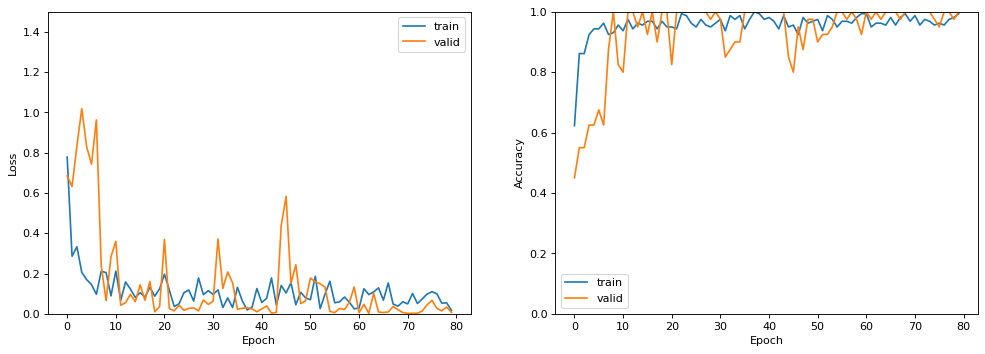

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 1.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

Guardando le curve il modello sembra avere delle buone perfomance, anche se oscillano leggermente in fase di validation, forse dovuto alla mancanza di dati o ad un batch size ridotto.

### Valutazione

Applicando il modello al test set, le performance risultano ottime, l'accuracy è pari a 0.99 e anche dalla matrice di confusione si può notare come solo un'osservazione sia al di fuori della diagonale principale.

In [ ]:
yc_pred = net.predict(X_test)

In [ ]:
y_pred = np.argmax(yc_pred, axis=1)

Classification report:
              precision    recall  f1-score   support

    big_mari       1.00      0.96      0.98        26
  rimbalzino       1.00      1.00      1.00        29
   ste_manzo       0.97      1.00      0.98        31

    accuracy                           0.99        86
   macro avg       0.99      0.99      0.99        86
weighted avg       0.99      0.99      0.99        86




Confusion matrix:
[[25  0  1]
 [ 0 29  0]
 [ 0  0 31]]





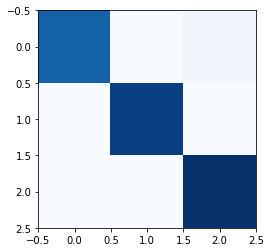

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(Y_test, label_encoder.inverse_transform(y_pred)))

print('\n\n')

# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(Y_test, label_encoder.inverse_transform(y_pred))
print(cm)

print('\n\n')

plt.imshow(cm, cmap=plt.cm.Blues)

Complessivamente pare essesere un buon modello con buone performance.

### Salvataggio modello

Il modello insieme alle sue specifiche viene salvato per un suo possibile utilizzo futuro

In [ ]:
net.save('mobile_net_v2.h5')

In [ ]:
# net = keras.models.load_model('mobile_net_v2.h5')

## Con Early Stopping

Si è provato inoltre ad aggiungere il metodo dell'earling stopping al modello già creato precedentemente.  
Esso è una forma di regolarizzazione utilizzata per ridurre l'overfitting durante l'addestramento.  

Bisogna comprendere fino a che punto l'addestramento migliora le performance e oltre tale punto, interrompere l'addestramento.

Il procedimento seguito per lo studio è il medesimo del precedente, con l'aggiunta dell'early stopping.

### Rete Base

In [ ]:
base_net = keras.applications.MobileNetV2(input_shape=(224,224,3), weights='imagenet', include_top=False)

### Specializzazione della rete

In [ ]:
def freeze_layers(net):
  for layer in net.layers:
    layer.trainable = False

In [ ]:
freeze_layers(base_net)

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

### Data Augmentation

In [ ]:
def data_augmentation(data):
  data = keras.layers.RandomFlip(mode= 'horizontal_and_vertical', seed=1)(data)
  data = keras.layers.RandomTranslation(height_factor= 0.2, width_factor=0.2,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=1,
    fill_value=0.0,)(data)
  
  data = keras.layers.RandomRotation(
    factor=0.2,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=1,
    fill_value=0.0
  )(data)
  data = keras.layers.RandomZoom(
    height_factor = (0.2, 0.3),
    width_factor=None,
    fill_mode="reflect",
    interpolation="bilinear",
    seed=1,
    fill_value=0.0
  )(data)
  data = keras.layers.RandomContrast(factor= 0.8, seed=1)(data)
  return data

In [ ]:
x= data_augmentation(x)

### Preprocessing

In [ ]:
x = keras.applications.mobilenet_v2.preprocess_input(x)

### Specializzazione

In [ ]:
x = base_net(x)
x =keras.layers.GlobalAveragePooling2D()(x)
x=keras.layers.Dense(512, activation = "relu")(x)
x=keras.layers.BatchNormalization()(x)
x=keras.layers.Dropout(0.3)(x)
x=keras.layers.Dense(128, activation = "relu")(x)
x=keras.layers.Dropout(0.1)(x)
x=keras.layers.Dense(32, activation = "relu")(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

### Creazione modello

In [ ]:
net = keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
net.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_translation_1 (Rando  (None, 224, 224, 3)      0         
 mTranslation)                                                   
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 224, 224, 3)      0   

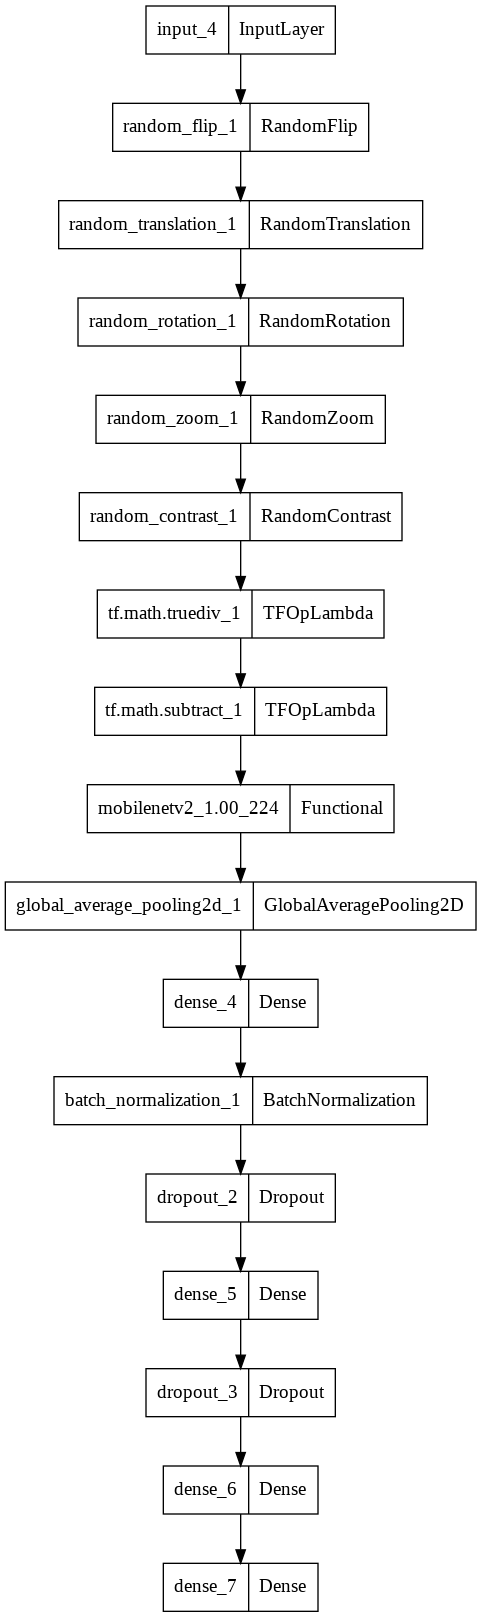

In [ ]:
keras.utils.plot_model(net)

### Training e fine tuning

In [ ]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

Viene inserito l'early stopping che monitorando il valore della loss function sul validation set, permette di interrompere l'addestramento dopo il 5 peggioramento.

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0.0001, 
                           verbose = 1, restore_best_weights = True) 

history = net.fit(X_train, YC_train,
          epochs=80,
          validation_split= 0.2, batch_size = 32, callbacks = [early_stop] );

Epoch 1/80
5/5 [==============================] - 5s 316ms/step - loss: 0.7335 - accuracy: 0.6730 - val_loss: 1.2355 - val_accuracy: 0.3750
Epoch 2/80
5/5 [==============================] - 0s 83ms/step - loss: 0.3115 - accuracy: 0.8616 - val_loss: 0.8370 - val_accuracy: 0.5500
Epoch 3/80
5/5 [==============================] - 0s 81ms/step - loss: 0.2500 - accuracy: 0.8805 - val_loss: 0.7183 - val_accuracy: 0.6500
Epoch 4/80
5/5 [==============================] - 0s 63ms/step - loss: 0.2550 - accuracy: 0.8679 - val_loss: 0.9362 - val_accuracy: 0.5250
Epoch 5/80
5/5 [==============================] - 0s 81ms/step - loss: 0.1313 - accuracy: 0.9623 - val_loss: 0.5685 - val_accuracy: 0.6000
Epoch 6/80
5/5 [==============================] - 0s 67ms/step - loss: 0.1475 - accuracy: 0.9497 - val_loss: 0.6861 - val_accuracy: 0.5000
Epoch 7/80
5/5 [==============================] - 0s 64ms/step - loss: 0.0962 - accuracy: 0.9623 - val_loss: 1.3464 - val_accuracy: 0.4000
Epoch 8/80
5/5 [==========

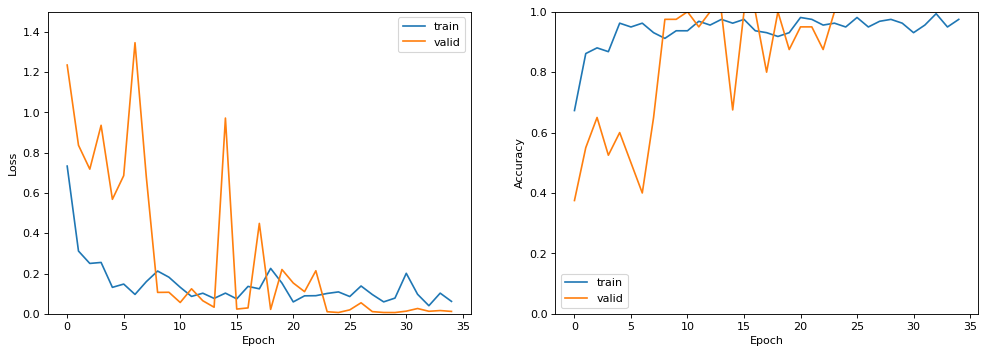

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 1.5])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

Inserendo l'early stopping il modello si ferma alla 32esima epoca di addestramento, mantenendo le performance in linea con il modello precedente.

### Valutazione

Per quanto riguarda le performance sul test set i risultati indicano un comportamento simile al modello senza l'early stopping sia a livello di accuracy che per la matrice di confusione.

In [ ]:
yc_pred = net.predict(X_test)

In [ ]:
y_pred = np.argmax(yc_pred, axis=1)

Classification report:
              precision    recall  f1-score   support

    big_mari       1.00      1.00      1.00        26
  rimbalzino       1.00      1.00      1.00        29
   ste_manzo       1.00      1.00      1.00        31

    accuracy                           1.00        86
   macro avg       1.00      1.00      1.00        86
weighted avg       1.00      1.00      1.00        86




Confusion matrix:
[[26  0  0]
 [ 0 29  0]
 [ 0  0 31]]





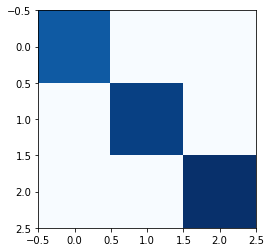

In [ ]:
print('Classification report:')
print(classification_report(Y_test, label_encoder.inverse_transform(y_pred)))

print('\n\n')
print('Confusion matrix:')
cm = confusion_matrix(Y_test, label_encoder.inverse_transform(y_pred))
print(cm)
print('\n\n')
plt.imshow(cm, cmap=plt.cm.Blues)

### Salvataggio modello

In [ ]:
net.save('mobile_net_v2_early_stopping.h5')

In [ ]:
# net = keras.models.load_model('mobile_net_v2_early_stopping.h5')

#VGG16

VGG16 è caratterizzato dall'applicazione di una serie di blocchi convoluzionali con dimensioni del kernel piccole, seguiti da due diversi layer fully connected che mappano a 4096 e infine layer finale che mappa a 1000, la dimensione del problema di classificazione originale. Questi ultimi layer in particolare richiedono un numero molto alto di parametri e anche rispetto al numero di operazioni richieste questa rete risulta essere molto complessa rispetto ad altre.

## Senza Early Stopping

Anche per questo modello il procedimento seguito è il medesimo, con la differenza che la rete di base che viene utilizzata è differente.

###Rete Base

In [ ]:
base_net_vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

58900480/58889256 [==============================] - 0s 0us/step


### Specializzazione della rete

In [ ]:
freeze_layers(base_net_vgg16)

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

###Data augmentation

In [ ]:
x= data_augmentation(x)

### Preprocessing 

Per utilizzare la rete già addestrata (VGG16) bisogna applicare al dataset a disposizione il medesimo 
preprocessing utilizzato sui dati per addestrare la rete.

In [ ]:
x = keras.applications.vgg16.preprocess_input(x)

###Specializzazione

Il modello preaddestrato adesso viene adeguato al caso specifico aggiungendo:

- un **layer dense**, aiuta a modificare la dimensionalità dell'output dal livello precedente in modo che il modello possa definire facilmente la relazione tra i valori dei dati in cui il modello sta lavorando.

- un **layer di dropout**, nel quale ogni unità nascosta (neurone) viene posta a 0 con una probabilità di 0,2. In altre parole, c'è una variazione del 20% che l'output di un dato neurone sarà forzato a 0.

- un'altro **layer dense**



- un **layer flatten**, converte le matrici multidimensionali in matrici unidimensionali appiattite o matrici unidimensionali.

- un **layer fully connected** (o **dense**) che contiene l'output, ossia la classificazione delle immagini di input, in base alle tre classi di riferimento ("rimbalzino", "big mari", "stemanzo"). In particolare, esso utilizza una rete neurale densa (Multi layer Perceptron), con funzione di attivazione "Softmax".

In [ ]:
# Output of the base model
x = base_net_vgg16(x)
x = keras.layers.Dense(32, activation = 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(16, activation = 'relu')(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

###Creazione modello

In [ ]:
net_vgg16 = keras.Model(inputs=inputs, outputs=outputs)

###Training e fine tuning

In [ ]:
net_vgg16.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

In [ ]:
history_vgg16 = net_vgg16.fit(X_train, YC_train,
          epochs=80,
          validation_split= 0.2, batch_size = 32);

Epoch 1/80
5/5 [==============================] - 9s 1s/step - loss: 5.2069 - accuracy: 0.3899 - val_loss: 1.2756 - val_accuracy: 0.6000
Epoch 2/80
5/5 [==============================] - 1s 216ms/step - loss: 4.0792 - accuracy: 0.4277 - val_loss: 1.3869 - val_accuracy: 0.6750
Epoch 3/80
5/5 [==============================] - 1s 214ms/step - loss: 3.1222 - accuracy: 0.5031 - val_loss: 1.2478 - val_accuracy: 0.7000
Epoch 4/80
5/5 [==============================] - 1s 215ms/step - loss: 2.7484 - accuracy: 0.4969 - val_loss: 1.2156 - val_accuracy: 0.7000
Epoch 5/80
5/5 [==============================] - 1s 215ms/step - loss: 3.0409 - accuracy: 0.5660 - val_loss: 1.1009 - val_accuracy: 0.7250
Epoch 6/80
5/5 [==============================] - 1s 217ms/step - loss: 1.8245 - accuracy: 0.5031 - val_loss: 1.0731 - val_accuracy: 0.7250
Epoch 7/80
5/5 [==============================] - 1s 218ms/step - loss: 1.8051 - accuracy: 0.5283 - val_loss: 0.9396 - val_accuracy: 0.6750
Epoch 8/80
5/5 [=======

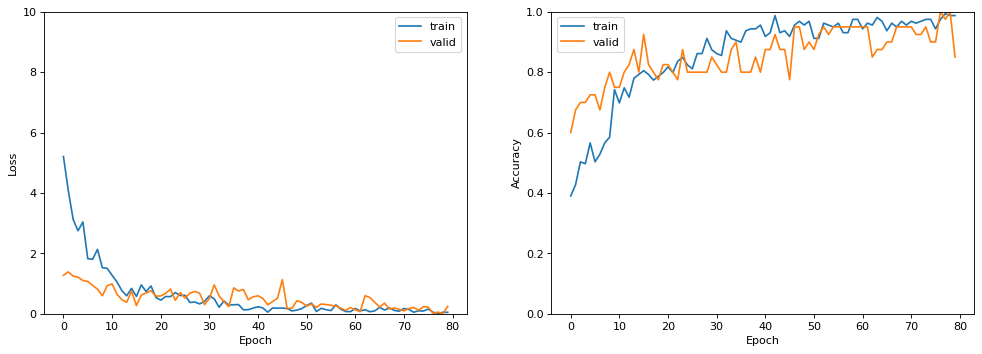

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.ylim([0.0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.ylim([0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

Anche in questo caso le performance sono buone, ma peggiori dei modelli con Mobile net V2, specialmente per quanto riguarda il validation set.

### Valutazione

Anche per il test set le performance sono peggiori rispetto ai modelli precedenti, registrando un'accuracy di 0.81, dalla matrice di confusione si può notare come il modello faccia fatica a distinguere "stemanzo" da "bigmari".

In [ ]:
yc_pred = net_vgg16.predict(X_test)

In [ ]:
y_pred = np.argmax(yc_pred, axis=1)

Classification report:
              precision    recall  f1-score   support

    big_mari       0.76      1.00      0.87        26
  rimbalzino       1.00      1.00      1.00        29
   ste_manzo       1.00      0.74      0.85        31

    accuracy                           0.91        86
   macro avg       0.92      0.91      0.91        86
weighted avg       0.93      0.91      0.91        86




Confusion matrix:
[[26  0  0]
 [ 0 29  0]
 [ 8  0 23]]





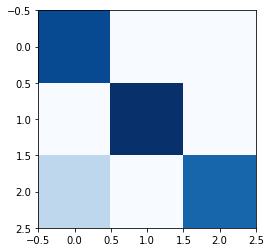

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(Y_test, label_encoder.inverse_transform(y_pred)))
print('\n\n')
#Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(Y_test, label_encoder.inverse_transform(y_pred))
print(cm)
print('\n\n')
plt.imshow(cm, cmap=plt.cm.Blues)

### Salvataggio modello

In [ ]:
net.save('vgg16.h5')

In [ ]:
# net = keras.models.load_model('mobile_net_v2_early_stopping.h5')

## Con Early Stopping

In questo caso viene riproposto l'ultimo studio effettuato con l'aggiunta dell'early stopping, ripetendo il medesimo procedimento.

###Rete base

In [ ]:
base_net_vgg16 = keras.applications.vgg16.VGG16(include_top=False, weights="imagenet", input_shape=(224,224,3))

###Specializzazione della rete

In [ ]:
freeze_layers(base_net_vgg16)

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))
x = inputs

###Data augmentation

In [ ]:
x= data_augmentation(x)

###Preprocessing

In [ ]:
x = keras.applications.vgg16.preprocess_input(x)

###Specializzazione

In [ ]:
x = base_net_vgg16(x)
x = keras.layers.Dense(32, activation = 'relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(16, activation = 'relu')(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

###Creazione modello

In [ ]:
net_vgg16 = keras.Model(inputs=inputs, outputs=outputs)

###Training e fine tuning

In [ ]:
net_vgg16.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(),
            metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5, min_delta = 0.0001, 
                           verbose = 1, restore_best_weights = True) 

history_vgg16 = net_vgg16.fit(X_train, YC_train,
          epochs=80,
          validation_split= 0.2, batch_size = 32, callbacks = [early_stop] );

Epoch 1/80
5/5 [==============================] - 3s 307ms/step - loss: 7.2368 - accuracy: 0.3145 - val_loss: 3.0866 - val_accuracy: 0.4500
Epoch 2/80
5/5 [==============================] - 1s 227ms/step - loss: 3.7912 - accuracy: 0.4214 - val_loss: 2.5784 - val_accuracy: 0.4500
Epoch 3/80
5/5 [==============================] - 1s 228ms/step - loss: 3.1502 - accuracy: 0.3774 - val_loss: 2.0811 - val_accuracy: 0.4500
Epoch 4/80
5/5 [==============================] - 1s 229ms/step - loss: 2.2372 - accuracy: 0.5283 - val_loss: 1.8761 - val_accuracy: 0.5750
Epoch 5/80
5/5 [==============================] - 1s 229ms/step - loss: 2.4987 - accuracy: 0.5220 - val_loss: 1.7394 - val_accuracy: 0.6000
Epoch 6/80
5/5 [==============================] - 1s 230ms/step - loss: 1.3203 - accuracy: 0.6352 - val_loss: 1.4945 - val_accuracy: 0.6000
Epoch 7/80
5/5 [==============================] - 1s 231ms/step - loss: 1.9642 - accuracy: 0.5912 - val_loss: 1.4924 - val_accuracy: 0.6000
Epoch 8/80
5/5 [====

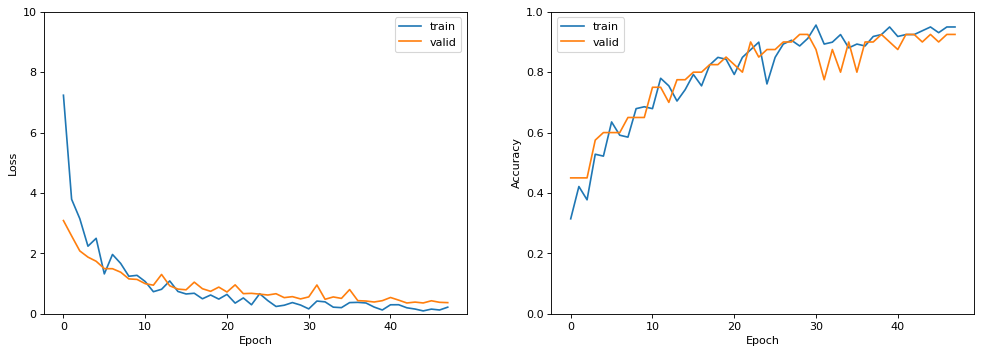

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(15, 5), dpi=80)
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.ylim([0.0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.ylim([0, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

L'early stopping ha terminato l'addestramento alla 48esima epoca, ottenendo performance leggermente inferiori sia per il training che il validation set rispetto a tutti gli altri tre modelli.

### Valutazione

Per quanto riguarda il test set i valori di accuracy ottenuti sono migliori rispetto al modello VGG16 senza early stopping

In [ ]:
yc_pred = net_vgg16.predict(X_test)

In [ ]:
y_pred = np.argmax(yc_pred, axis=1)

Classification report:
              precision    recall  f1-score   support

    big_mari       0.86      0.96      0.91        26
  rimbalzino       0.97      1.00      0.98        29
   ste_manzo       1.00      0.87      0.93        31

    accuracy                           0.94        86
   macro avg       0.94      0.94      0.94        86
weighted avg       0.95      0.94      0.94        86




Confusion matrix:
[[25  1  0]
 [ 0 29  0]
 [ 4  0 27]]





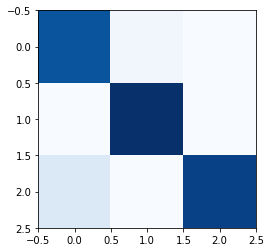

In [ ]:
# Classification report
print('Classification report:')
print(classification_report(Y_test, label_encoder.inverse_transform(y_pred)))
print('\n\n')
# Confusion matrix
print('Confusion matrix:')
cm = confusion_matrix(Y_test, label_encoder.inverse_transform(y_pred))
print(cm)
print('\n\n')
plt.imshow(cm, cmap=plt.cm.Blues)

Il modello sembra fornire ottime performance sotto ogni aspetto, ma comunque inferiori rispetto a MobileNet

### Salvataggio modello

In [ ]:
net.save('vgg16_early_stopping.h5')

In [ ]:
# net = keras.models.load_model('mobile_net_v2_early_stopping.h5')

# LIVE DEMO

Viene implementato il riconoscimento del viso live, sfruttando la libreria open cv e il miglior modello risultato nello studio precedente ovvero Mobile V2 net.

Per ogni frame vengono croppate le facce presenti e successivamente tramite la funzione predict vengono classficate nelle tre possibili classi.

In [ ]:
def find_faces_live(img, min_height, min_width, face_detector):
    

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, minNeighbors=4, scaleFactor=1.15, minSize=(min_height,min_width))
    for (x,y,w,h) in faces:

        face = img[y:y + h, x:x + w]
        resized_face = cv.resize(face, dsize=(224, 224), interpolation=cv.INTER_CUBIC)
        pred = net.predict(np.expand_dims(resized_face, axis=0))
        index = np.argmax(pred, axis=1)
        category = CATEGORIES[int(index)]
        prob = round(pred[0][index[0]]*100, 1)
        if prob < 90:
            category = 'Unknown'
        cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        cv.putText(img, category, (x+5,y-5), cv.FONT_HERSHEY_PLAIN, 1, (255,255,255), 2)
    return img

In [ ]:
net = keras.models.load_model('mobile_net_v2.h5')

In [ ]:
face_detector = cv.CascadeClassifier(cv.data.haarcascades + "haarcascade_frontalface_default.xml")

cap = cv.VideoCapture(0)
if not cap.isOpened():
    print("Error")
    exit()
while True:
    ret, frame = cap.read()
    if not ret:
        print("Error")
        break
    
    frame = find_faces_live(frame, 100, 100, face_detector)
    cv.imshow('frame', frame)
    time.sleep(0.05)
    
    
    if cv.waitKey(1) == ord('q'):
        break
# When everything done, release the capture
cap.release()
cv.destroyAllWindows()

Error
Error
